In [1]:
import numpy as np
import matplotlib.pyplot as plt
% matplotlib notebook
nelx=120
nely=60
width=0.07
heigth=0.02
nels=nelx*nely

E1=50.0e9
nu1=0.25
E2=0.1e9
nu2=0.4
E3=200e9
nu3=0.3

coordx=np.linspace(0,width,nelx+1)
coordy=np.linspace(0,heigth,nely+1)
coordy=np.insert(coordy, int(nely/2)+1, heigth/2)
coord=np.zeros(((nelx+1)*(nely+2),2))
etpl=np.zeros(((nelx)*(nely),4))

# calculate coordinates of global nodes
idx=0
for j in range(nely+2):
    for i in range(nelx+1):
        coord[idx,:]=np.array([coordx[i],coordy[j]])
        idx=idx+1

# calculate connectivity matrix etpl
idx=0
etplall_bot=np.arange((1+int(nely/2))*(1+nelx)).reshape(1+int(nely/2),nelx+1)
etplall_top=np.arange((1+int(nely/2))*(1+nelx)).reshape(1+int(nely/2),nelx+1)+np.max(etplall_bot)+1
for i in range(int(nely/2)):
    for j in range(nelx):        
         etpl[idx]=np.array([etplall_bot[i,j],etplall_bot[i,j+1],etplall_bot[i+1,j+1],etplall_bot[i+1,j]])
         idx=idx+1
        
for i in range(int(nely/2)):
    for j in range(nelx):        
         etpl[idx]=np.array([etplall_top[i,j],etplall_top[i,j+1],etplall_top[i+1,j+1],etplall_top[i+1,j]])
         idx=idx+1   
etpl=etpl.astype(int)

class shape_rec:
    def __init__(self,nelx,nely,width,heigth,coord,etpl):
        self.el_width= width/nelx 
        self.el_heigth= heigth/nely
        self.gp=(1/3)**0.5*np.array([[-1,1,1,-1],[-1,-1,1,1]])
        self.x1=-1
        self.x2=1
        self.x3=1
        self.x4=-1
        self.y1=-1
        self.y2=-1
        self.y3=1
        self.y4=1 
        self.J=np.array([[(0.5*width/nelx)/1,0],[0,(0.5*heigth/nely)/1]])

    def N(self,x,y):
        n1=1/4 * (x-self.x2)*(y-self.y4)
        n2=-1/4  * (x-self.x1)*(y-self.y3)
        n3=1/4 * (x-self.x4)*(y-self.y2)    
        n4=-1/4 * (x-self.x3)*(y-self.y1)
        output=np.array([[n1,0,n2,0,n3,0,n4,0],[0,n1,0,n2,0,n3,0,n4]])
        return output
    
    def B(self,x,y):
        output= 1/4 * \
                np.array([[y-self.y4,0,self.y3-y,0, \
                           y-self.y2,0,self.y1-y,0], \
                          [0,x-self.x2,0,self.x1-x, \
                           0,x-self.x4,0,self.x3-x], \
                 [x-self.x2,y-self.y4,self.x1-x,self.y3-y, \
                  x-self.x4,y-self.y2,self.x3-x,self.y1-y]])
        output[0,:]=output[0,:]/(self.el_width/2) #(self.el_width/2) corresponds to a
        output[1,:]=output[1,:]/(self.el_heigth/2)
        output[2,::2]=output[2,::2]/(self.el_heigth/2)
        output[2,1::2]=output[2,1::2]/(self.el_width/2)
        return output

## plain stress case    
# def D(E,nu):
#     return E/(1-nu**2)*np.array([[1,nu,0],[nu,1,0],[0,0,(1-nu)/2]])
## plane strain case
def D(E,nu):
    return E/((1+nu)*(1-2*nu))*np.array([[1-nu,nu,0],[nu,1-nu,0],[0,0,(1-2*nu)/2]])

obj=shape_rec(nelx,nely,width,heigth,coord,etpl)

x=np.linspace(-1,1,10)
y=np.linspace(-1,1,10)
[X,Y]=np.meshgrid(x,y)


from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve

Det=np.linalg.det(obj.J)

ke=np.zeros((8,8))
ke2=np.zeros((8,8))
ke3=np.zeros((8,8))
# me=np.zeros((8,8))
for gp in range(4):
    x=obj.gp[0,gp]
    y=obj.gp[1,gp]
    ke=ke+1*Det*np.matmul(np.transpose(obj.B(x,y)),np.matmul(D(E1,nu1),obj.B(x,y)))
    ke2=ke2+1*Det*np.matmul(np.transpose(obj.B(x,y)),np.matmul(D(E2,nu2),obj.B(x,y)))
    ke3=ke3+1*Det*np.matmul(np.transpose(obj.B(x,y)),np.matmul(D(E3,nu3),obj.B(x,y)))
    
K=np.zeros(((nelx+1)*(nely+2)*2,(nelx+1)*(nely+2)*2))


for i in range(nels): #nels
    for row in range(4):
        for col in range(4):
            indr=etpl[i][row]*2
            indc=etpl[i][col]*2
            coordx_center=(coord[etpl[i][0],0]+coord[etpl[i][3],0])/2
            coordy_center=(coord[etpl[i][0],1]+coord[etpl[i][3],1])/2           
            if coordx_center>0.015 and  coordx_center<0.055 and coordy_center>0.006 and coordy_center<0.014:
                K[indr:(indr+2),indc:(indc+2)]=K[indr:(indr+2),indc:(indc+2)]+ke[row*2:(row*2+2),col*2:(col*2+2)]        
            elif (coordx_center>0.005 and  coordx_center<=0.015 and coordy_center>0.01015) or \
        (coordx_center>=0.055 and  coordx_center<0.065 and coordy_center<0.00985):
                K[indr:(indr+2),indc:(indc+2)]=K[indr:(indr+2),indc:(indc+2)]+ke2[row*2:(row*2+2),col*2:(col*2+2)]
            else:
                K[indr:(indr+2),indc:(indc+2)]=K[indr:(indr+2),indc:(indc+2)]+ke3[row*2:(row*2+2),col*2:(col*2+2)]

%matplotlib notebook
p=E3/(obj.el_width*(1-nu1**2))*10
halfcrackwidth=0
## test with springs
##ALL NODES##############################################################################
int_nodes=np.where(np.logical_and(coord[:,1]==(heigth/2),coord[:,0]>=halfcrackwidth))[0]
# int_nodes=np.where(coord[:,1]==(heigth/2))[0]
int_bot=int_nodes[0:int(int_nodes.shape[0]/2)]
int_top=int_nodes[int(int_nodes.shape[0]/2):]
dofs_nodes=np.append(int_nodes*2,int_nodes*2+1)
### for hor and vert dofs
dofs_bot=np.append(int_bot*2,int_bot*2+1)
dofs_top=np.append(int_top*2,int_top*2+1)
## TO CONNECT ALL THE NODES
for i in dofs_nodes:
    K[i,i]=K[i,i]+p 
for i,j in zip(dofs_bot,dofs_top):
    K[i,j]=K[i,j]-p
    K[j,i]=K[j,i]-p
    
###NODES INSIDE CRACK#################################################################
##to have a crack
int_nodes_disconnect=np.where(np.logical_or(np.logical_and(coord[:,1]==(heigth/2),
                                             np.logical_and(coord[:,0]>=0.005,coord[:,0]<0.02)),
                                           np.logical_and(coord[:,1]==(heigth/2),
                                             np.logical_and(coord[:,0]>0.05,coord[:,0]<=0.065))))[0]
##to have a continuous domain
int_nodes_disconnect=np.array([])

# ##or a crack just under the strain gage
# int_nodes_disconnect=np.where(np.logical_and(coord[:,1]==(heigth/2),
#                                              np.logical_and(coord[:,0]>=0.005,coord[:,0]<0.024)))[0]

# int_nodes=np.where(coord[:,1]==(heigth/2))[0]
int_bot_disconnect=int_nodes_disconnect[0:int(int_nodes_disconnect.shape[0]/2)]
int_top_disconnect=int_nodes_disconnect[int(int_nodes_disconnect.shape[0]/2):]
# ###to disconnect only hor dofs, comment otherwise
dofs_nodes_disconnect=int_nodes_disconnect*2
dofs_bot_disconnect=int_bot_disconnect*2
dofs_top_disconnect=int_top_disconnect*2

for i in dofs_nodes_disconnect:
    K[i,i]=K[i,i]-p  
for i,j in zip(dofs_bot_disconnect,dofs_top_disconnect):
    K[i,j]=K[i,j]+p
    K[j,i]=K[j,i]+p

In [2]:
##########################################Boundary conditions###############################################
#--4/5--#   even numbers -> horizontal dofs
#|      |   odd numbers -> vert dofs
#6/7   2/3
#|      |
#--0/1--#


# P_horiz=1.7e6*5*0
# P_vert=1e6*100
# exx=nu*P_vert/E; # strain in horizontal direction
# eyy=P_vert/E; # strain in vertical direction
# dxy=heigth*P_horiz/(E/(2*(1+nu))) # shear displacement (horizontal direction)

BC_type=['displacement','pressure']
BC_dofs=[[0,1,5],[4]]
BC_val=[[],[]]
## initialize force vector
F=np.zeros(((nelx+1)*(nely+2)*2,1))
# newman (force) BC :
all_dofs= np.arange((nelx+1)*(nely+2)*2)
## degrees of freedom at top and bottom
top_nodes=np.where(coord[:,1]==heigth)[0]
dofs4=top_nodes*2  # dofs x direction
dofs5=top_nodes*2+1  # dofs y direction 
bot_nodes=np.where(coord[:,1]==0)[0]
dofs0=bot_nodes*2  # dofs x direction
dofs1=bot_nodes*2+1  # dofs y direction 
left_nodes=np.where(coord[:,0]==0)[0]
dofs6=left_nodes*2  # dofs x direction
dofs7=left_nodes*2+1  # dofs y direction 
right_nodes=np.where(coord[:,0]==width)[0]
dofs2=right_nodes*2  # dofs x direction
dofs3=right_nodes*2+1  # dofs y direction 
#extra_dofs:

d1=0.02
d2=0.02
nodes_11=np.where(coord[:,0]==0)[0]
nodes_12=np.where(coord[nodes_11,1]<=d1)[0]
nodes_1=nodes_11[nodes_12]
dofs8=nodes_1*2  # dofs x direction
dofs9=nodes_1*2+1  # dofs y direction

nodes_21=np.where(coord[:,0]==width)[0]
nodes_22=np.where(coord[nodes_21,1]>=(heigth-d2))[0]
nodes_2=nodes_21[nodes_22]
dofs10=nodes_2*2  # dofs x direction
dofs11=nodes_2*2+1  # dofs y direction

dofs_BC=[dofs0,dofs1,dofs2,dofs3,dofs4,dofs5,dofs6,dofs7,dofs8,dofs9,dofs10,dofs11] ##all dofs on Boundaries as shown on drawing
# +4 extra dofs groups


## forces -------------------------------------#
BC_dofs=[[5,1,6,2],[4]] #we always give the displacements first, then the forces
BC_val=[['np.ones((len(dofs5)))*0.0 - 8e-6', \
         '0.0*np.ones((len(dofs1)))' , \
         '0.0*np.ones((len(dofs6)))',\
        '0.0*np.ones((len(dofs2)))-25e-6'], \
        ['0*np.ones((len(dofs4)))*1e6*width/nely' ]]

BC_dofs=[[6,2],[5,1]] #we always give the displacements first, then the forces
BC_val=[['0.0*np.ones((len(dofs6)))' ,\
        '0.0*np.ones((len(dofs2)))-60e-6' ], \
        ['np.ones((len(dofs5)))*50e6*width/nelx*(-1)',\
        'np.ones((len(dofs1)))*50e6*width/nelx' ]]

# BC_dofs=[[],[5,1,6,2]] #we always give the displacements first, then the forces
# BC_val=[[], \
#         ['np.ones((len(dofs5)))*50e6*width/nelx*(-1)',\
#         'np.ones((len(dofs1)))*50e6*width/nelx' ,\
#         'np.ones((len(dofs6)))*20e6*width/nelx',\
#         'np.ones((len(dofs2)))*20e6*width/nelx*(-1)']]


nmn_dofs=np.concatenate(np.array(dofs_BC)[BC_dofs[1]])
f=[];
for expr in BC_val[1]:  
    f=np.concatenate((f,eval(expr)))
F[nmn_dofs,0]=f
        
####displacements --(comment when no disp BC...)---------------------------#
d=[];

for expr in BC_val[0]:
    d=np.concatenate((d,eval(expr)))

fixed_dofs=np.concatenate(np.array(dofs_BC)[BC_dofs[0]])
free_dofs=all_dofs[np.in1d(all_dofs, fixed_dofs,invert=True)]

for id in range(len(fixed_dofs)):
    i=fixed_dofs[id];
    rows=K[free_dofs,i];
    F[free_dofs,0]=F[free_dofs,0]-rows*d[id];
    K[:,i]=0; K[i,:]=0; K[i,i]=1;
    F[i]=d[id];

##==============================================================
    

K = csr_matrix(K)
U= spsolve(K,F)
#U= np.linalg.solve(K,F) # without sparsing K

#############################################Calculate stresses###############################################
## plot bottom half:

sigma_b=np.zeros((int(nely/2)+1,nelx+1,3))
sigma_t=np.zeros((int(nely/2)+1,nelx+1,3))
ux_mat=U[::2].reshape((nely+2, nelx+1))
uy_mat=U[1::2].reshape((nely+2, nelx+1))
ux_mat_b=ux_mat[0:int(nely/2)+1,:]
uy_mat_b=uy_mat[0:int(nely/2)+1,:]
ux_mat_t=ux_mat[int(nely/2)+1:,:]
uy_mat_t=uy_mat[int(nely/2)+1:,:]

##botom
Dub=np.gradient(ux_mat_b,obj.el_heigth,obj.el_width); #to check width or heigth first
Dvb=np.gradient(uy_mat_b,obj.el_heigth,obj.el_width);
Dxub=Dub[1]
Dyub=Dub[0]
Dxvb=Dvb[1]
Dyvb=Dvb[0]
Bstress=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,1]]);
n_nd=0
for i in range(int(nely/2)+1):
    for j in range(nelx+1):
        strain=np.matmul(Bstress,np.array([[Dxub[i,j]],[Dyvb[i,j]],[Dxvb[i,j]],[Dyub[i,j]]]));
        coordx_center=coord[n_nd,0]
        coordy_center=coord[n_nd,1]
        
        if coordx_center>0.015 and  coordx_center<0.055 and coordy_center>0.006 and coordy_center<0.014:
            stress=np.matmul(D(E1,nu1),strain);
        elif (coordx_center>0.005 and  coordx_center<=0.015 and coordy_center>0.01015) or \
        (coordx_center>=0.055 and  coordx_center<0.065 and coordy_center<0.00985):
            stress=np.matmul(D(E2,nu2),strain);
        else:
            stress=np.matmul(D(E3,nu3),strain); 
            
        sigma_b[i,j,0]=stress[0]; # 0 for sxx
        sigma_b[i,j,1]=stress[1]; # 1 for syy
        sigma_b[i,j,2]=stress[2]; # 2 for tauxy
        n_nd=n_nd+1
#top
Dut=np.gradient(ux_mat_t,obj.el_heigth,obj.el_width); #to check width or heigth first
Dvt=np.gradient(uy_mat_t,obj.el_heigth,obj.el_width);
Dxut=Dut[1]
Dyut=Dut[0]
Dxvt=Dvt[1]
Dyvt=Dvt[0]
Bstress=np.array([[1,0,0,0],[0,1,0,0],[0,0,1,1]]);
for i in range(int(nely/2)+1):
    for j in range(nelx+1):
        strain=np.matmul(Bstress,np.array([[Dxut[i,j]],[Dyvt[i,j]],[Dxvt[i,j]],[Dyut[i,j]]]));

        coordx_center=coord[n_nd,0]
        coordy_center=coord[n_nd,1]
        
        if coordx_center>0.015 and  coordx_center<0.055 and coordy_center>0.006 and coordy_center<0.014:
            stress=np.matmul(D(E1,nu1),strain);
        elif (coordx_center>0.005 and  coordx_center<=0.015 and coordy_center>0.01015) or \
        (coordx_center>=0.055 and  coordx_center<0.065 and coordy_center<0.00985):
            stress=np.matmul(D(E2,nu2),strain);
        else:
            stress=np.matmul(D(E3,nu3),strain); 
            
            
        sigma_t[i,j,0]=stress[0]; # 0 for sxx
        sigma_t[i,j,1]=stress[1]; # 1 for syy
        sigma_t[i,j,2]=stress[2]; # 2 for tauxy
        n_nd=n_nd+1
print(n_nd)
print(np.max(etpl)+1)


7502
7502


<IPython.core.display.Javascript object>


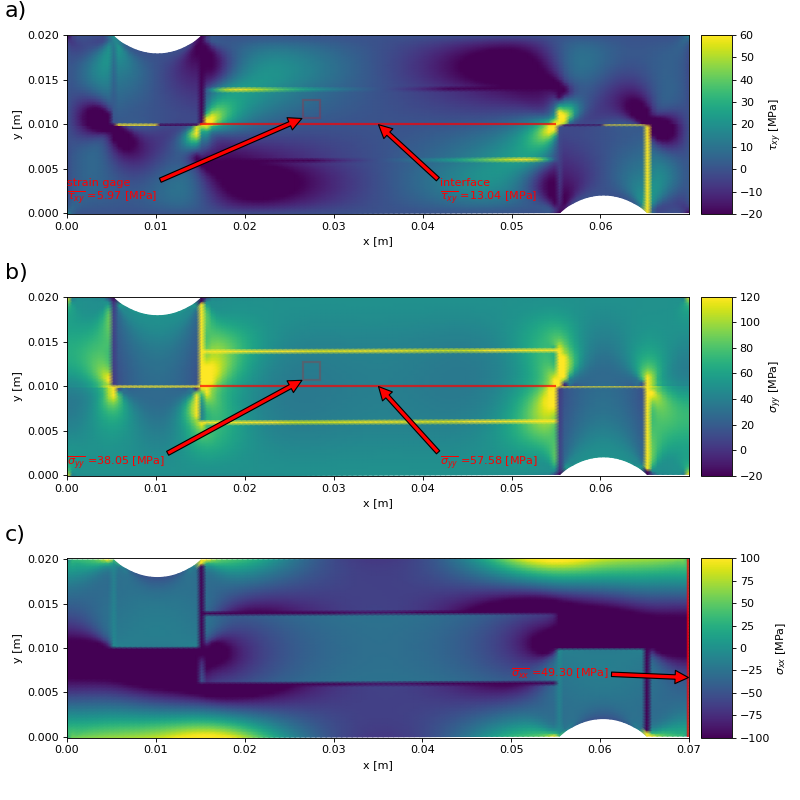

vertical stress : -135.52 [MPa]
horizontal stress : 49.30 [MPa]
apparent friction coefficient :0.99


In [5]:
########################################Plotting#####################################################
from mpl_toolkits.axes_grid1 import make_axes_locatable

%matplotlib notebook
f5=plt.figure(5,figsize=(10,10))
ax5=f5.add_subplot(311)

st2plt=2
coordx_bot=((coord[:,0]+U[::2]).reshape((nely+2, nelx+1)))[0:int(nely/2)+1,:];
coordy_bot=((coord[:,1]+U[1::2]).reshape((nely+2, nelx+1)))[0:int(nely/2)+1,:];
coordx_top=((coord[:,0]+U[::2]).reshape((nely+2, nelx+1)))[int(nely/2)+1:,:];
coordy_top=((coord[:,1]+U[1::2]).reshape((nely+2, nelx+1)))[int(nely/2)+1:,:]

stressmap1=ax5.pcolormesh(coordx_bot,coordy_bot, \
                      -sigma_b[:,:,st2plt]/1e6, shading='Gouraud')
stressmap2=ax5.pcolormesh(coordx_top,coordy_top, \
                      -sigma_t[:,:,st2plt]/1e6, shading='Gouraud')

#ax5.set_aspect('equal')

divider = make_axes_locatable(ax5)
cax2 = divider.append_axes("right", size="5%", pad=0.15)


ax5.set_xlabel('x [m]')
ax5.set_ylabel('y [m]')
ax5.set_aspect('equal');
# Visualizing colorbar part -start
plt.colorbar(stressmap2, cax=cax2,label='$\\tau_{xy}$ [MPa]')
#######################################################################
ax6=f5.add_subplot(312)
st2plt=1
stressmap3=ax6.pcolormesh(coordx_bot,coordy_bot, \
                      -sigma_b[:,:,st2plt]/1e6, shading='Gouraud')
stressmap4=ax6.pcolormesh(coordx_top,coordy_top, \
                      -sigma_t[:,:,st2plt]/1e6, shading='Gouraud')

divider = make_axes_locatable(ax6)
cax1 = divider.append_axes("right", size="5%", pad=0.15)

ax6.set_xlabel('x [m]')
ax6.set_ylabel('y [m]')
ax6.set_aspect('equal');
# Visualizing colorbar part -start
plt.colorbar(stressmap4, cax=cax1,label='$\sigma_{yy}$ [MPa]')
################################################################################
ax7=f5.add_subplot(313)
mu_s=0.7;
## for fault parallel stress
# stressmap5=ax7.pcolormesh(coordx_bot,coordy_bot, \
#                       (-sigma_b[:,:,2]+mu_s*sigma_b[:,:,1])/1e6, shading='Gouraud')
# stressmap6=ax7.pcolormesh(coordx_top,coordy_top, \
#                       (-sigma_t[:,:,2]+mu_s*sigma_t[:,:,1])/1e6, shading='Gouraud')

stressmap5=ax7.pcolormesh(coordx_bot,coordy_bot, \
                      (sigma_b[:,:,0])/1e6, shading='Gouraud')
stressmap6=ax7.pcolormesh(coordx_top,coordy_top, \
                      (sigma_t[:,:,0])/1e6, shading='Gouraud')

# ##plot interface stress values
x7=(coordx[np.where(np.logical_and(coordx>0.015, coordx<0.055))])
y71=((-sigma_t[0,np.where(np.logical_and(coordx>0.015, coordx<0.055)),1])*1e-6)[0,:]

y712=((uy_mat_t[0,np.where(np.logical_and(coordx>0.015, coordx<0.055))]-
       uy_mat_b[-1,np.where(np.logical_and(coordx>0.015, coordx<0.055))])*-p/500)[0,:]

y72=((-sigma_t[0,np.where(np.logical_and(coordx>0.015, coordx<0.055)),2])*1e-6)[0,:]

y722=((ux_mat_t[0,np.where(np.logical_and(coordx>0.015, coordx<0.055))]-
       ux_mat_b[-1,np.where(np.logical_and(coordx>0.015, coordx<0.055))])*-p/500)[0,:]

# ax7.plot(x7,y71)
# ax7.plot(x7,y72,'r')
# ax7.plot(x7,y712,'-.')
# ax7.plot(x7,y722,'-.k')
# ax72.plot(x7,y722/y712)
divider = make_axes_locatable(ax7)
cax2 = divider.append_axes("right", size="5%", pad=0.15)
ax7.set_xlabel('x [m]')
ax7.set_ylabel('y [m]')
ax7.set_aspect('equal');

stressmap1.set_clim(-20,60)
stressmap2.set_clim(-20,60)
stressmap3.set_clim(-20,120)
stressmap4.set_clim(-20,120)
stressmap5.set_clim(-100,100)
stressmap6.set_clim(-100,100)
# Visualizing colorbar part -start
plt.colorbar(stressmap6, cax=cax2,label='$\sigma_{xx}$ [MPa]')
# #################################################################################

# # fig.colorbar(mesh1,ax=ax1)
# ##label axis a), b)
import string
axs=[ax5,ax6,ax7]
for n, ax in enumerate(axs): 
    ax.text(-0.1, 1.1, string.ascii_lowercase[n] + ')', transform=ax.transAxes, 
            size=20)#, weight='bold')
    
############annotations########################
sgloc=[0.0115+0.015,0.0047-0.004+0.01]
import matplotlib
r1 = matplotlib.patches.Rectangle((sgloc[0],sgloc[1]), 2e-3, 2e-3, 
                                     facecolor='None',edgecolor='red', linewidth=2.0, alpha=0.2)
r2 = matplotlib.patches.Rectangle((0.005,0.01), 0.01,0.01, 
                                     facecolor='None',edgecolor='black', linewidth=5.0, alpha=1)
r3= matplotlib.patches.Rectangle((sgloc[0],sgloc[1]), 2e-3, 2e-3, 
                                 facecolor='None',edgecolor='red', linewidth=2.0, alpha=0.2)
r4 = matplotlib.patches.Rectangle((0.055,0), 0.01,0.01, 
                                     facecolor='None',edgecolor='black', linewidth=5.0, alpha=1)
r5 = matplotlib.patches.Rectangle((0.015,0.006), 0.04,0.008, 
                                     facecolor='None',edgecolor='blue', linewidth=5.0, alpha=1)
interf = matplotlib.patches.Rectangle((0.015,0.01), 0.04,0, 
                                     facecolor='None',edgecolor='red', linewidth=2.0, alpha=0.7)
interf2 = matplotlib.patches.Rectangle((0.015,0.01), 0.04,0, 
                                     facecolor='None',edgecolor='red', linewidth=2.0, alpha=0.7)
side_right = matplotlib.patches.Rectangle((width,0.0), 0.0,0.02, 
                                     facecolor='None',edgecolor='red', linewidth=4.0, alpha=0.7)
side_top = matplotlib.patches.Rectangle((0.0,0.0198), width,0.0, 
                                     facecolor='None',edgecolor='red', linewidth=4.0, alpha=0.7)
ax5.add_patch(r1)
# ax5.add_patch(r2)
# ax5.add_patch(r4)
# ax5.add_patch(r5)
ax5.add_patch(interf)
ax6.add_patch(r3)
ax6.add_patch(interf2)
ax7.add_patch(side_right)
# ax7.add_patch(side_top)
####averages interface and strain gage ##########################

coordy_top=coordy[int(nely/2)+1:]
sbset=sigma_t[np.where(np.logical_and(coordy_top>=sgloc[1],coordy_top<=sgloc[1]+2e-3))[0],:,1]
vals=sbset[:,np.where(np.logical_and(coordx>=sgloc[0],coordx<=sgloc[0]+2e-3))[0]]

sbset=sigma_t[np.where(np.logical_and(coordy_top>=sgloc[1],coordy_top<=sgloc[1]+2e-3))[0],:,2]
vals_shear=sbset[:,np.where(np.logical_and(coordx>=sgloc[0],coordx<=sgloc[0]+2e-3))[0]]

ax5.annotate('strain gage'+ '\n' + '$\overline{\\tau_{xy}}$' + ' =' + str("{:.2f}".format(-np.mean(vals_shear)*1e-6)) + ' [MPa]',
             xy=(sgloc[0],sgloc[1]), xytext=(0,1e-3),color='red',
             arrowprops=dict(facecolor='red', shrink=0.005))
ax5.annotate('interface'+ '\n' + '$\overline{\\tau_{xy}}$' + ' =' + str("{:.2f}".format(-np.mean(sigma_t[0,np.where(np.logical_and(coordx>0.015, coordx<0.055)),2])*1e-6)) + ' [MPa]', 
             xy=(width/2,heigth/2), xytext=(width/2*1.2,1e-3),color='red',
             arrowprops=dict(facecolor='red', shrink=0.005))


ax6.annotate('$\overline{\sigma_{yy}}$' + ' =' + str("{:.2f}".format(-np.mean(vals)*1e-6)) + ' [MPa]',
             xy=(sgloc[0],sgloc[1]), xytext=(0,1e-3),color='red',
             arrowprops=dict(facecolor='red', shrink=0.005))
ax6.annotate('$\overline{\sigma_{yy}}$' + ' =' + \
             str("{:.2f}".format(-np.mean(sigma_t[0,np.where(np.logical_and(coordx>0.015, coordx<0.055)),1])*1e-6)) + \
             ' [MPa]', xy=(width/2,heigth/2), xytext=(width/2*1.2,1e-3),color='red',
             arrowprops=dict(facecolor='red', shrink=0.005))


### average confining pressure measured on the edges
pres_vert=-np.mean(sigma_t[-1,:,1])*1e-6
print('vertical stress : '+str("{:.2f}".format(pres_vert))+' [MPa]')
pres_hor=(-np.mean(sigma_t[:,0,0])-np.mean(sigma_b[:,0,0]))/2 *1e-6
print('horizontal stress : '+str("{:.2f}".format(pres_hor))+' [MPa]')
print('apparent friction coefficient :'+ str("{:.2f}".format((pres_hor/50))))

# ax7.annotate('$\overline{\sigma_{yy}}$' + ' = ' +str("{:.2f}".format(pres_vert))+' [MPa]',
#              xy=(width/2,heigth), xytext=(width/2,heigth-0.01),color='red',
#              arrowprops=dict(facecolor='red', shrink=0.005))
ax7.annotate('$\overline{\sigma_{xx}}$' + ' =' + \
             str("{:.2f}".format(pres_hor))+' [MPa]', xy=(width,heigth/3),
             xytext=(width-0.02,heigth/3),color='red',
             arrowprops=dict(facecolor='red', shrink=0.005))
ax7.set_xlim([0.0,0.07])
f5.tight_layout()
# f5.savefig('loading_triax_hete_crack.pdf')
# f5.savefig('loading_triax_hete.pdf')

In [6]:
f5.savefig('loading_triax_forces2.pdf')

<IPython.core.display.Javascript object>


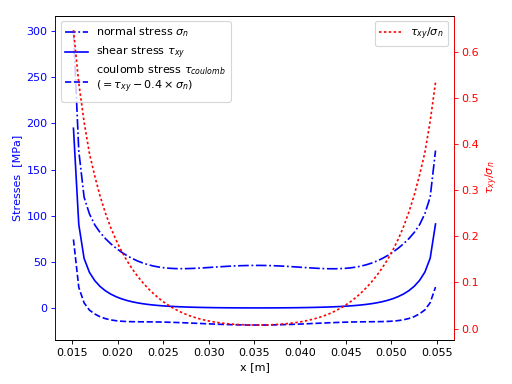

In [27]:
f8=plt.figure(8)
ax81=f8.add_subplot(111)
ax812=ax81.twinx()
ax81.plot(x7,y712,'-.b',label='normal stress ' + r'$\sigma_n$')
ax81.plot(x7,y722,'-b',label='shear stress ' + r'$\tau_{xy}$')
ax81.plot(x7,y722-0.4*y712,'--b',label='coulomb stress ' + r'$\tau_{coulomb}$' + '\n' + r'$(=\tau_{xy}-0.4 \times \sigma_n)$')
ax812.plot(x7,y722/y712,':r',label=r'$\tau_{xy} / \sigma_n$')
ax81.set_xlabel('x [m]')
ax81.set_ylabel('Stresses  [MPa]')
ax81.legend(loc='upper left')
ax812.legend(loc='upper right')
ax812.set_ylabel(r'$\tau_{xy} / \sigma_n$')
ax81.tick_params(axis='y', colors='blue')
ax812.spines['left'].set_color('blue')
ax81.yaxis.label.set_color('blue')
ax812.tick_params(axis='y', colors='red')
ax812.spines['right'].set_color('red')
ax812.yaxis.label.set_color('red')

In [28]:
f8.tight_layout()
f8.savefig('interface_forces_triax.pdf')

In [34]:
ds=0.02/60
np.sum(sigma_t[:-1,0,0]+sigma_b[:-1,0,0])/1e6 * ds
# len(sigma_t[:-1,0,0])

-0.64691140503338473

<IPython.core.display.Javascript object>


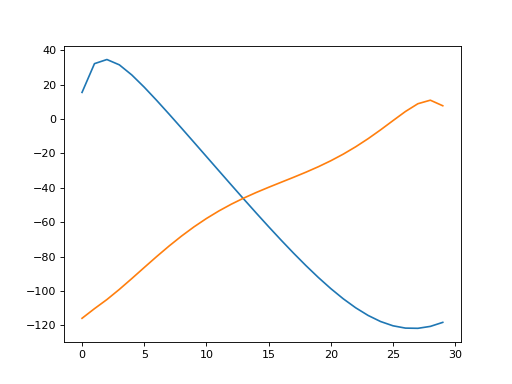

-45.31049044721783

In [59]:

f9=plt.figure(9)
ax91=f9.add_subplot(111)
ax91.plot(sigma_b[:-1,0,0]/1e6)
ax91.plot(sigma_t[:-1,0,0]/1e6)
np.mean(sigma_b[:-1,0,0])/1e6
np.mean(sigma_t[:-1,0,0])/1e6
# len(sigma_b[:-1,0,0])

In [23]:
(np.mean(sigma_b[:,0,0])/1e6+np.mean(sigma_t[:,0,0])/1e6)/2


-33.250363834449267

In [24]:
-33.646*0.02

-0.6729200000000001

In [63]:
np.savetxt('x.txt',x7,delimiter=',')
np.savetxt('normal.txt',y712,delimiter=',')
np.savetxt('shear.txt',y722,delimiter=',')